##Analysing the emotion of presentation

Installation

In [296]:
!pip install pydub websocket-client

In [297]:
!pip install pypinyin

In [298]:
!pip install zhipuai

In [299]:
!pip install --upgrade zhipuai

In [300]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [326]:
import json

# Load the JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Capstone/Poem Database/poem_database.json', 'r') as file:
    data = json.load(file)

# Extract poem titles
poem_name_list = [poem['title'] for poem in data['poems']]
print("Available Poems:")
for index, title in enumerate(poem_name_list):
    print(f"{index + 1}: {title}")

# Prompt user to select a poem by number or name
while True:
    user_input = input("Please enter the number or name of the poem you want to select: ").strip()

    # Check if the input is a number
    if user_input.isdigit():
        poem_index = int(user_input) - 1
        if 0 <= poem_index < len(poem_name_list):
            poem_name = poem_name_list[poem_index]
            print(f"You selected: {poem_name}")
            break
        else:
            print("Invalid number. Please enter a valid number corresponding to the available poems.")
    else:
        # Check if the input is a poem name
        if user_input in poem_name_list:
            poem_index = poem_name_list.index(user_input)
            poem_name = poem_name_list[poem_index]
            print(f"You selected: {poem_name}")
            break
        else:
            print("Invalid name. Please enter a valid poem name or number.")

    print()  # Add a newline for better readability

Available Poems:
1: 感遇四首其一
2: 感遇四首其二
3: 感遇四首其三
4: 感遇四首其四
5: 下终南山过斛斯山人宿置酒
6: 月下独酌
7: 春思
8: 望岳
9: 赠卫八处士
10: 佳人
11: 梦李白二首·其一
12: 梦李白二首·其二
13: 送别
14: 送綦毋潜落第还乡
15: 青溪
16: 渭川田家
17: 西施咏
18: 同从弟南斋玩月忆山阴崔少府
19: 郡斋雨中与诸文士燕集
20: 初发扬子寄元大校书
21: 寄全椒山中道士
22: 长安遇冯著
23: 夕次盱眙县
24: 东郊
25: 送杨氏女
26: 晨诣超师院读禅经
27: 溪居
28: 塞上曲·其一
29: 塞下曲
30: 关山月
31: 子夜四时歌·春歌
32: 子夜四时歌·夏歌
33: 子夜四时歌·秋歌
34: 子夜四时歌·冬歌
35: 烈女操
36: 游子吟
37: 登幽州台歌
38: 古意
39: 送陈章甫
40: 琴歌
41: 听董大弹胡笳弄兼寄语房给事
42: 听安万善吹觱篥歌
43: 夜归鹿门山歌
44: 庐山谣寄卢侍御虚舟
45: 梦游天姥吟留别 
46: 金陵酒肆留别 
Please enter the number or name of the poem you want to select: 感遇四首其一
You selected: 感遇四首其一


In [327]:
# Debugging: Output the value and type of poem_index
try:
    print("Debug: poem_index value is", poem_index)
    print("Debug: poem_index type is", type(poem_index))

    # Retrieve the poem's content and audio path
    poem_content = data['poems'][poem_index]['content']
    poem_path = data['poems'][poem_index]['audio_path']

    # Print the content of the poem
    print("Poem Content:")
    print(poem_content)

except IndexError as e:
    print("IndexError:", e)
    print("The value of poem_index may be out of range. Please check the available poems.")
except Exception as e:
    print("An unexpected error occurred:", e)

Debug: poem_index value is 0
Debug: poem_index type is <class 'int'>
Poem Content:
孤鸿海上来，池潢不敢顾。侧见双翠鸟，巢在三珠树。矫矫珍木巅，得无金丸惧？美服患人指，高明逼神恶？今我游冥冥，弋者何所慕！


In [328]:
from pydub import AudioSegment
import wave

def convert_mp3_to_pcm(mp3_file_path, output_pcm_path):
    # Load MP3 file
    audio = AudioSegment.from_mp3(mp3_file_path)

    # Convert to PCM
    samples = audio.set_channels(1).set_frame_rate(16000).get_array_of_samples()

    # Save to a WAV file (PCM data)
    with wave.open(output_pcm_path, 'wb') as wav:
        wav.setnchannels(1)  # Mono
        wav.setsampwidth(audio.sample_width)
        wav.setframerate(16000)
        wav.writeframes(samples.tobytes())

    print(f"File converted and saved to {output_pcm_path}")

Convert MP3 files or wav files to wav files.

In [329]:
# Define the base path for your Google Drive
base_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/Poem Database/'

# Construct the full path to the audio file
full_poem_path = base_path + data['poems'][poem_index]['audio_path'].lstrip('./')  # Remove leading './' if necessary

# Convert and save directly to Colab's local file system
output_pcm_path = "/content/output_file.wav"
convert_mp3_to_pcm(full_poem_path, output_pcm_path)

File converted and saved to /content/output_file.wav


Play the MP3 file

In [330]:
from IPython.display import Audio, display

def play_original_mp3(mp3_file_path):
    # Create an Audio widget
    audio = Audio(mp3_file_path)
    # Display and play the audio
    display(audio)

# Play the original MP3 using the full path
play_original_mp3(full_poem_path)

Utilize the iFly API to listen to and extract the spoken words from the audio file.

In [331]:
import websocket
import datetime
import hashlib
import base64
import hmac
import json
from urllib.parse import urlencode
import time
import ssl
from wsgiref.handlers import format_date_time
from datetime import datetime
from time import mktime
import _thread as thread

STATUS_FIRST_FRAME = 0  # 第一帧的标识
STATUS_CONTINUE_FRAME = 1  # 中间帧标识
STATUS_LAST_FRAME = 2  # 最后一帧的标识


class Ws_Param(object):
    # 初始化
    def __init__(self, APPID, APIKey, APISecret, AudioFile):
        self.APPID = APPID
        self.APIKey = APIKey
        self.APISecret = APISecret
        self.AudioFile = AudioFile

        # 公共参数(common)
        self.CommonArgs = {"app_id": self.APPID}
        # 业务参数(business)，更多个性化参数可在官网查看
        self.BusinessArgs = {"domain": "iat", "language": "zh_cn", "accent": "mandarin", "vinfo":1,"vad_eos":10000}

    # 生成url
    def create_url(self):
        url = 'wss://ws-api.xfyun.cn/v2/iat'
        # 生成RFC1123格式的时间戳
        now = datetime.now()
        date = format_date_time(mktime(now.timetuple()))

        # 拼接字符串
        signature_origin = "host: " + "ws-api.xfyun.cn" + "\n"
        signature_origin += "date: " + date + "\n"
        signature_origin += "GET " + "/v2/iat " + "HTTP/1.1"
        # 进行hmac-sha256进行加密
        signature_sha = hmac.new(self.APISecret.encode('utf-8'), signature_origin.encode('utf-8'),
                                 digestmod=hashlib.sha256).digest()
        signature_sha = base64.b64encode(signature_sha).decode(encoding='utf-8')

        authorization_origin = "api_key=\"%s\", algorithm=\"%s\", headers=\"%s\", signature=\"%s\"" % (
            self.APIKey, "hmac-sha256", "host date request-line", signature_sha)
        authorization = base64.b64encode(authorization_origin.encode('utf-8')).decode(encoding='utf-8')
        # 将请求的鉴权参数组合为字典
        v = {
            "authorization": authorization,
            "date": date,
            "host": "ws-api.xfyun.cn"
        }
        # 拼接鉴权参数，生成url
        url = url + '?' + urlencode(v)
        # print("date: ",date)
        # print("v: ",v)
        # 此处打印出建立连接时候的url,参考本demo的时候可取消上方打印的注释，比对相同参数时生成的url与自己代码生成的url是否一致
        # print('websocket url :', url)
        return url


# 收到websocket消息的处理
def on_message(ws, message):
    try:
        code = json.loads(message)["code"]
        sid = json.loads(message)["sid"]
        if code != 0:
            errMsg = json.loads(message)["message"]
            print("sid:%s call error:%s code is:%s" % (sid, errMsg, code))

        else:
            data = json.loads(message)["data"]["result"]["ws"]
            # print(json.loads(message))
            result = ""
            for i in data:
                for w in i["cw"]:
                    result += w["w"]
            print("sid:%s call success!,data is:%s" % (sid, json.dumps(data, ensure_ascii=False)))
    except Exception as e:
        print("receive msg,but parse exception:", e)



# 收到websocket错误的处理
def on_error(ws, error):
    print("### error:", error)


# 收到websocket关闭的处理
def on_close(ws,a,b):
    print("### closed ###")


# 收到websocket连接建立的处理
def on_open(ws):
    def run(*args):
        frameSize = 8000  # 每一帧的音频大小
        intervel = 0.04  # 发送音频间隔(单位:s)
        status = STATUS_FIRST_FRAME  # 音频的状态信息，标识音频是第一帧，还是中间帧、最后一帧

        with open(wsParam.AudioFile, "rb") as fp:
            while True:
                buf = fp.read(frameSize)
                # 文件结束
                if not buf:
                    status = STATUS_LAST_FRAME
                # 第一帧处理
                # 发送第一帧音频，带business 参数
                # appid 必须带上，只需第一帧发送
                if status == STATUS_FIRST_FRAME:

                    d = {"common": wsParam.CommonArgs,
                         "business": wsParam.BusinessArgs,
                         "data": {"status": 0, "format": "audio/L16;rate=16000",
                                  "audio": str(base64.b64encode(buf), 'utf-8'),
                                  "encoding": "raw"}}
                    d = json.dumps(d)
                    ws.send(d)
                    status = STATUS_CONTINUE_FRAME
                # 中间帧处理
                elif status == STATUS_CONTINUE_FRAME:
                    d = {"data": {"status": 1, "format": "audio/L16;rate=16000",
                                  "audio": str(base64.b64encode(buf), 'utf-8'),
                                  "encoding": "raw"}}
                    ws.send(json.dumps(d))
                # 最后一帧处理
                elif status == STATUS_LAST_FRAME:
                    d = {"data": {"status": 2, "format": "audio/L16;rate=16000",
                                  "audio": str(base64.b64encode(buf), 'utf-8'),
                                  "encoding": "raw"}}
                    ws.send(json.dumps(d))
                    time.sleep(1)
                    break
                # 模拟音频采样间隔
                time.sleep(intervel)
        ws.close()

    thread.start_new_thread(run, ())


if __name__ == "__main__":
    # 测试时候在此处正确填写相关信息即可运行
    time1 = datetime.now()
    wsParam = Ws_Param(APPID='6a272d13', APISecret='YmI0ZTljYjdlMTY5MzY4YzY3YTc4Yjdk',
                       APIKey='b39181ec6c5522fae460f3047f16868b',
                       AudioFile=r'/content/output_file.wav')
    websocket.enableTrace(False)
    wsUrl = wsParam.create_url()
    ws = websocket.WebSocketApp(wsUrl, on_message=on_message, on_error=on_error, on_close=on_close)
    ws.on_open = on_open
    ws.run_forever(sslopt={"cert_reqs": ssl.CERT_NONE})
    time2 = datetime.now()
    print(time2-time1)


sid:iat000d560e@dx19378d8c194a140802 call success!,data is:[{"bg": 5, "cw": [{"sc": 0, "w": "感"}]}, {"bg": 49, "cw": [{"w": "遇", "sc": 0}]}, {"bg": 109, "cw": [{"sc": 0, "w": "四"}]}, {"bg": 149, "cw": [{"sc": 0, "w": "首"}]}, {"bg": 185, "cw": [{"sc": 0, "w": "之"}]}, {"bg": 217, "cw": [{"sc": 0, "w": "一"}]}]
sid:iat000d560e@dx19378d8c194a140802 call success!,data is:[{"bg": 357, "cw": [{"sc": 0, "w": "，"}]}, {"bg": 357, "cw": [{"sc": 0, "w": "张"}]}, {"bg": 401, "cw": [{"sc": 0, "w": "九"}]}, {"bg": 433, "cw": [{"w": "龄", "sc": 0}]}]
sid:iat000d560e@dx19378d8c194a140802 call success!,data is:[{"bg": 824, "cw": [{"w": "，", "sc": 0}]}, {"bg": 824, "cw": [{"sc": 0, "w": "孤"}]}, {"bg": 868, "cw": [{"sc": 0, "w": "鸿"}]}, {"bg": 892, "cw": [{"sc": 0, "w": "海"}]}, {"bg": 968, "cw": [{"sc": 0, "w": "上来"}]}]
sid:iat000d560e@dx19378d8c194a140802 call success!,data is:[{"bg": 1142, "cw": [{"sc": 0, "w": "，"}]}, {"bg": 1142, "cw": [{"sc": 0, "w": "池"}]}, {"bg": 1198, "cw": [{"sc": 0, "w": "潢"}]}, {"b

Extract the words detected along with their corresponding timestamps, and store this information in a variable for future use.

In [332]:
import websocket
import json
import base64
import hmac
import hashlib
from urllib.parse import urlencode
from wsgiref.handlers import format_date_time
from datetime import datetime
from time import mktime
import time
import ssl
import _thread as thread

STATUS_FIRST_FRAME = 0
STATUS_CONTINUE_FRAME = 1
STATUS_LAST_FRAME = 2
global word_timings

class Ws_Param(object):
    def __init__(self, APPID, APIKey, APISecret, AudioFile):
        self.APPID = APPID
        self.APIKey = APIKey
        self.APISecret = APISecret
        self.AudioFile = AudioFile
        self.CommonArgs = {"app_id": self.APPID}
        self.BusinessArgs = {"domain": "iat", "language": "zh_cn", "accent": "mandarin", "vinfo":1, "vad_eos":10000}

    def create_url(self):
        url = 'wss://ws-api.xfyun.cn/v2/iat'
        now = datetime.now()
        date = format_date_time(mktime(now.timetuple()))
        signature_origin = "host: ws-api.xfyun.cn\n" + "date: " + date + "\n" + "GET /v2/iat HTTP/1.1"
        signature_sha = hmac.new(self.APISecret.encode('utf-8'), signature_origin.encode('utf-8'), hashlib.sha256).digest()
        signature_sha = base64.b64encode(signature_sha).decode('utf-8')
        authorization_origin = f"api_key=\"{self.APIKey}\", algorithm=\"hmac-sha256\", headers=\"host date request-line\", signature=\"{signature_sha}\""
        authorization = base64.b64encode(authorization_origin.encode('utf-8')).decode('utf-8')
        v = {"authorization": authorization, "date": date, "host": "ws-api.xfyun.cn"}
        url = url + '?' + urlencode(v)
        return url

word_timings = []

def on_message(ws, message):
    global word_timings
    try:
        response = json.loads(message)
        if response["code"] != 0:
            print(f"Error: {response['message']} (Code: {response['code']})")
        else:
            data = response["data"]["result"]["ws"]
            for i in data:
                for w in i["cw"]:
                    word = w['w']
                    start_time = int(i['bg']) * 10
                    word_timings.append((start_time, word))
    except Exception as e:
        print("Parsing error:", e)

def on_error(ws, error):
    print("Error:", error)

def on_close(ws, a, b):
    global word_timings
    print("WebSocket closed")
    print("Final Word Timings:", word_timings)

def on_open(ws):
    def run(*args):
        frameSize = 8000
        intervel = 0.04
        status = STATUS_FIRST_FRAME
        with open(wsParam.AudioFile, "rb") as fp:
            while True:
                buf = fp.read(frameSize)
                if not buf:
                    status = STATUS_LAST_FRAME
                if status == STATUS_FIRST_FRAME:
                    d = {"common": wsParam.CommonArgs, "business": wsParam.BusinessArgs, "data": {"status": 0, "format": "audio/L16;rate=16000", "audio": str(base64.b64encode(buf), 'utf-8'), "encoding": "raw"}}
                    ws.send(json.dumps(d))
                    status = STATUS_CONTINUE_FRAME
                elif status == STATUS_CONTINUE_FRAME:
                    d = {"data": {"status": 1, "format": "audio/L16;rate=16000", "audio": str(base64.b64encode(buf), 'utf-8'), "encoding": "raw"}}
                    ws.send(json.dumps(d))
                elif status == STATUS_LAST_FRAME:
                    d = {"data": {"status": 2, "format": "audio/L16;rate=16000", "audio": str(base64.b64encode(buf), 'utf-8'), "encoding": "raw"}}
                    ws.send(json.dumps(d))
                    time.sleep(1)
                    break
                time.sleep(intervel)
        ws.close()
    thread.start_new_thread(run, ())

if __name__ == "__main__":
    wsParam = Ws_Param(APPID='6a272d13', APISecret='YmI0ZTljYjdlMTY5MzY4YzY3YTc4Yjdk', APIKey='b39181ec6c5522fae460f3047f16868b', AudioFile=r'/content/output_file.wav')
    websocket.enableTrace(False)
    wsUrl = wsParam.create_url()
    ws = websocket.WebSocketApp(wsUrl, on_message=on_message, on_error=on_error, on_close=on_close)
    ws.on_open = on_open
    ws.run_forever(sslopt={"cert_reqs": ssl.CERT_NONE})

    # Use word_timings as needed after the WebSocket connection closes.

WebSocket closed
Final Word Timings: [(50, '感'), (490, '遇'), (1090, '四'), (1490, '首'), (1850, '之'), (2170, '一'), (3570, '，'), (3570, '张'), (4010, '九'), (4330, '龄'), (8240, '，'), (8240, '孤'), (8680, '鸿'), (8920, '海'), (9680, '上来'), (11420, '，'), (11420, '池'), (11980, '潢'), (12500, '不敢'), (13220, '顾'), (15020, '，'), (15020, '侧'), (15460, '见'), (15980, '双'), (16540, '翠鸟'), (18160, '，'), (18160, '巢'), (18560, '在'), (19280, '三'), (19760, '珠'), (20160, '树'), (22220, '，'), (22220, '瞧瞧'), (23300, '真'), (23580, '木'), (23940, '电'), (25500, '，'), (25500, '得'), (25820, '五金'), (26580, '玩具'), (28900, '，'), (28900, '美'), (29380, '服'), (30020, '患'), (30500, '人'), (30820, '指'), (32330, '，'), (32330, '高明'), (33530, '逼'), (33930, '神'), (34290, '雾'), (36880, '，'), (36880, '今'), (37320, '我'), (37760, '游'), (37960, '冥冥'), (39820, '，'), (39820, '一'), (40340, '者'), (40980, '何'), (41340, '所'), (41860, '慕'), (42330, '。')]


Map the timestamps onto the waveform graph to segment the waveform and identify the sound wave corresponding to each word. This is a magnified version for demonstration purposes. Since Chinese characters cannot be displayed accurately, their Pinyin representations are used for identification.

<ipython-input-333-56d0b848c239>:38: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  plt.tight_layout()


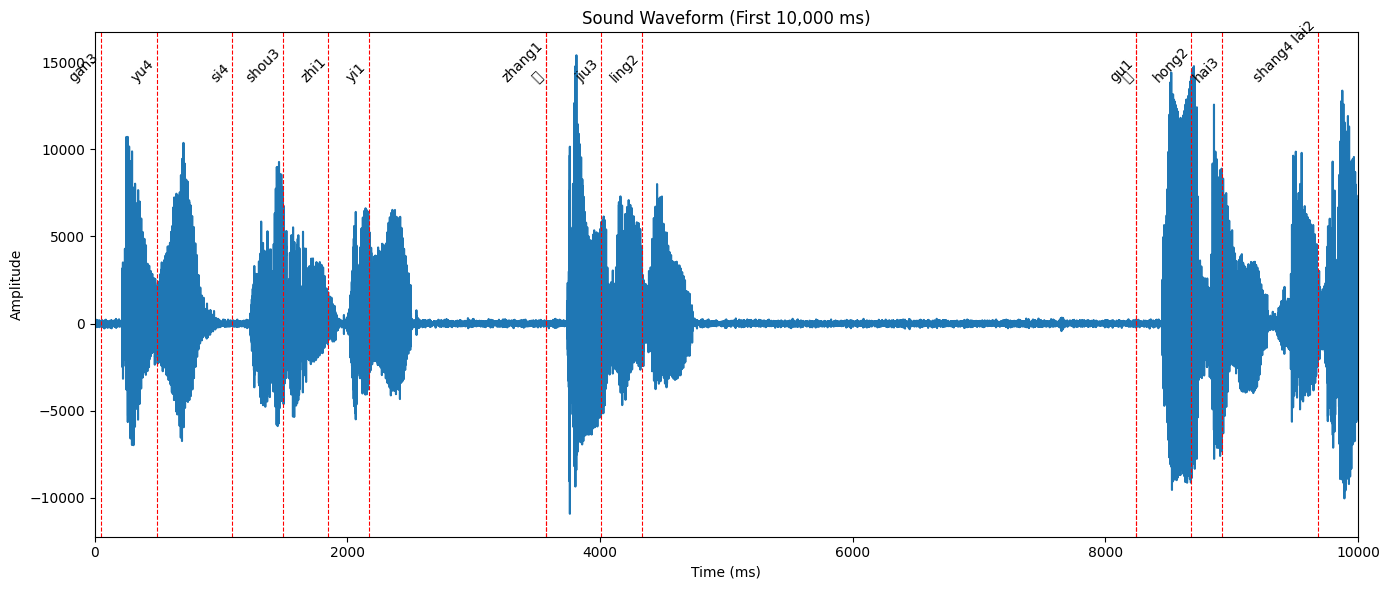

In [333]:
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
from pypinyin import pinyin, Style

# Load your audio file
audio = AudioSegment.from_mp3("/content/output_file.wav")

# Convert the audio to a numpy array
samples = np.array(audio.get_array_of_samples())

# Generate time values in milliseconds
time = np.linspace(0, len(audio), num=len(samples))

# Focus on the first 10,000 ms
end_time = 10000
end_index = int(len(samples) * (end_time / len(audio)))

# Plot the waveform for the first 10,000 ms
plt.figure(figsize=(14, 6))
plt.plot(time[:end_index], samples[:end_index])
plt.title("Sound Waveform (First 10,000 ms)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

# Function to convert Chinese text to Pinyin
def chinese_to_pinyin(text):
    return ' '.join([item[0] for item in pinyin(text, style=Style.TONE3)])

# Annotate the words on the waveform
for (ms, word) in word_timings:
    if ms <= end_time:
        plt.axvline(x=ms, color='r', linestyle='--', linewidth=0.8)
        pinyin_word = chinese_to_pinyin(word)
        plt.text(ms, max(samples[:end_index]) * 0.9, pinyin_word, rotation=45, ha='right')

plt.xlim(0, end_time)
plt.tight_layout()
plt.show()

The complete mapping of timestamps onto the waveform graph.

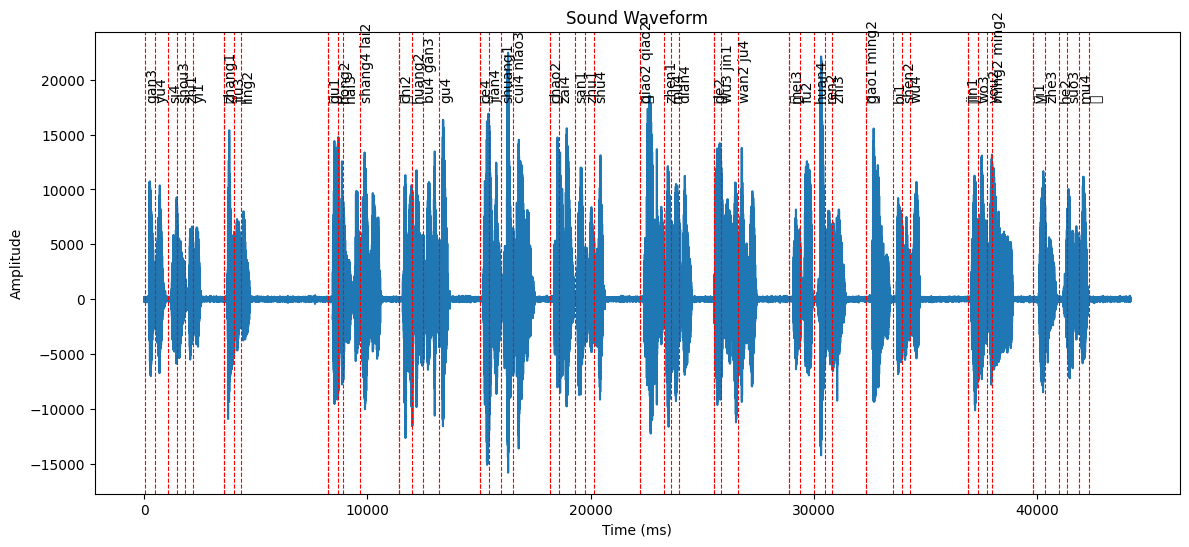

In [334]:
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
from pypinyin import pinyin, Style

# Load your audio file
audio = AudioSegment.from_mp3("/content/output_file.wav")

# Convert the audio to a numpy array
samples = np.array(audio.get_array_of_samples())

# Generate time values in milliseconds
time = np.linspace(0, len(audio), num=len(samples))

# Plot the waveform
plt.figure(figsize=(14, 6))
plt.plot(time, samples)
plt.title("Sound Waveform")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

# Function to convert Chinese text to Pinyin
def chinese_to_pinyin(text):
    return ' '.join([item[0] for item in pinyin(text, style=Style.TONE3)])

# Annotate the words on the waveform
for (ms, word) in word_timings:
    pinyin_word = chinese_to_pinyin(word)
    plt.axvline(x=ms, color='r', linestyle='--', linewidth=0.8)
    plt.text(ms, max(samples) * 0.8, pinyin_word, rotation=90, verticalalignment='bottom')

plt.show()

According to a researcher at EdUHK, the emotions conveyed while presenting a poem depend on several factors: stress (relative amplitude), duration (time spent reading each word), pauses (time paused after reading each word), and tone (changes in relative frequency/amplitude). All these factors are relative to the previous words presented by the same speaker.

In the earlier version of the analysis, duration was simply measured as the time elapsed between two consecutive words. However, the new version distinguishes between pauses and actual reading duration. Actual duration refers to the time spent reading the word, while pauses occur when no words are spoken. On the graph, the flat regions represent pauses, while the peaks indicate actual reading duration. By employing a dynamic threshold, we can effectively identify the regions that correspond to pauses, which are marked in green.

In [335]:
'''

from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt

def smooth_signal(signal, window_len=1000):
    """Smooth the signal using a simple moving average."""
    if len(signal) < window_len:
        window_len = len(signal)
    window = np.ones(int(window_len)) / float(window_len)
    return np.convolve(signal, window, 'same')

def calculate_dynamic_threshold(samples, factor=1.5):
    """Calculate a dynamic threshold based on the median amplitude of the signal."""
    median_amplitude = np.median(np.abs(samples))
    return median_amplitude * factor

def detect_pauses(audio, factor=1.5, min_silence_len=100, debounce_time=500):
    samples = np.array(audio.get_array_of_samples())
    samples = smooth_signal(samples, window_len=5000)
    sample_rate = audio.frame_rate

    amplitude_threshold = calculate_dynamic_threshold(samples, factor=factor)
    print("Calculated Amplitude Threshold:", amplitude_threshold)

    silent = np.abs(samples) < amplitude_threshold
    silent_segments = []
    current_start = None
    last_end = 0

    for i, is_silent in enumerate(silent):
        if is_silent:
            if current_start is None:
                current_start = i
        else:
            if current_start is not None:
                duration = (i - current_start) * 1000 / sample_rate
                if duration >= min_silence_len:
                    start_time = current_start * 1000 / sample_rate
                    if silent_segments and start_time <= last_end + debounce_time:
                        silent_segments[-1] = (silent_segments[-1][0], silent_segments[-1][1] + duration)
                    else:
                        silent_segments.append((start_time, duration))
                    last_end = start_time + duration
                current_start = None

    if current_start is not None:
        duration = (len(silent) - current_start) * 1000 / sample_rate
        start_time = current_start * 1000 / sample_rate
        if silent_segments and start_time <= last_end + debounce_time:
            silent_segments[-1] = (silent_segments[-1][0], silent_segments[-1][1] + duration)
        else:
            silent_segments.append((start_time, duration))

    return silent_segments

def plot_audio_with_pauses(audio, pauses):
    samples = np.array(audio.get_array_of_samples())
    times = np.linspace(0, len(samples) / audio.frame_rate, num=len(samples))

    plt.figure(figsize=(15, 5))
    plt.plot(times, samples, label='Waveform')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for start, duration in pauses:
        plt.axvline(x=start/1000, color='r', linestyle='--', label='Pause Start' if 'Pause Start' not in plt.gca().get_legend_handles_labels()[1] else '')
        plt.axvspan(start/1000, (start + duration)/1000, color='y', alpha=0.3, label='Pause' if 'Pause' not in plt.gca().get_legend_handles_labels()[1] else '')

    plt.title('Audio Waveform and Detected Pauses')
    plt.legend()
    plt.show()

def analyze_audio_features(audio_file):
    audio = AudioSegment.from_file(audio_file)
    pauses = detect_pauses(audio)
    if pauses:
        print("Detected pauses (start time, duration):", pauses)
    else:
        print("No pauses detected based on the current settings.")
    plot_audio_with_pauses(audio, pauses)
    return pauses

# Example usage with the specified audio file path
pauses = analyze_audio_features('/content/output_file.wav')
print("Global Pauses:", pauses)
'''

'\n\nfrom pydub import AudioSegment\nimport numpy as np\nimport matplotlib.pyplot as plt\n\ndef smooth_signal(signal, window_len=1000):\n    """Smooth the signal using a simple moving average."""\n    if len(signal) < window_len:\n        window_len = len(signal)\n    window = np.ones(int(window_len)) / float(window_len)\n    return np.convolve(signal, window, \'same\')\n\ndef calculate_dynamic_threshold(samples, factor=1.5):\n    """Calculate a dynamic threshold based on the median amplitude of the signal."""\n    median_amplitude = np.median(np.abs(samples))\n    return median_amplitude * factor\n\ndef detect_pauses(audio, factor=1.5, min_silence_len=100, debounce_time=500):\n    samples = np.array(audio.get_array_of_samples())\n    samples = smooth_signal(samples, window_len=5000)\n    sample_rate = audio.frame_rate\n\n    amplitude_threshold = calculate_dynamic_threshold(samples, factor=factor)\n    print("Calculated Amplitude Threshold:", amplitude_threshold)\n\n    silent = np.ab

The main update from the original code is switching from a median-based threshold calculation to an RMS (Root Mean Square) energy-based approach, which is generally more effective for speech analysis since it better captures the energy variations in audio. Additionally, I added audio normalization, reduced the threshold sensitivity (factor from 2.5 to 1.2), and increased the minimum silence length to 500ms to better distinguish between actual pauses and natural brief silences in speech.

Average Threshold: 0.08551395916542179
Detected pauses (start time, duration): [(775.25, 1305.125), (2445.5, 1316.0625), (4661.5, 3815.3125), (8926.25, 919.6875), (10478.25, 1180.6875), (13508.625, 1823.6875), (17169.1875, 1346.75), (20511.25, 2917.875), (24277.125, 2158.3125), (27279.25, 1815.5625), (30901.5625, 1745.375), (34675.5625, 2460.875), (38853.9375, 2479.0625), (42190.3125, 1979.125)]


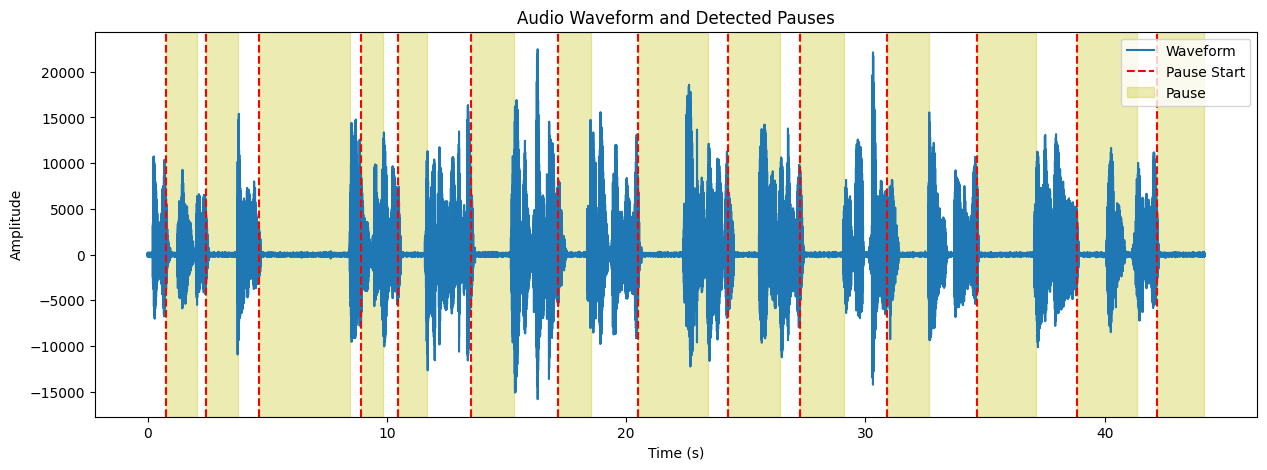

Global Pauses: [(775.25, 1305.125), (2445.5, 1316.0625), (4661.5, 3815.3125), (8926.25, 919.6875), (10478.25, 1180.6875), (13508.625, 1823.6875), (17169.1875, 1346.75), (20511.25, 2917.875), (24277.125, 2158.3125), (27279.25, 1815.5625), (30901.5625, 1745.375), (34675.5625, 2460.875), (38853.9375, 2479.0625), (42190.3125, 1979.125)]


In [336]:
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt

def smooth_signal(signal, window_len=1000):
    """Smooth the signal using a simple moving average."""
    if len(signal) < window_len:
        window_len = len(signal)
    window = np.ones(int(window_len)) / float(window_len)
    return np.convolve(signal, window, 'same')

def calculate_dynamic_threshold(samples, window_size=44100, factor=1.2):
    """Calculate threshold using RMS energy"""
    def rms(x):
        return np.sqrt(np.mean(np.square(x)))

    thresholds = []
    for i in range(0, len(samples), window_size):
        window = samples[i:i + window_size]
        local_threshold = rms(window) * factor
        thresholds.extend([local_threshold] * len(window))
    return np.array(thresholds[:len(samples)])

def detect_pauses(audio, min_silence_len=500, debounce_time=300):
    """Detect pauses in audio using dynamic thresholding."""
    samples = np.array(audio.get_array_of_samples())

    # Convert stereo to mono if necessary
    if audio.channels == 2:
        samples = samples.reshape((-1, 2)).mean(axis=1)

    # Normalize samples
    samples = samples / np.max(np.abs(samples))

    # Apply smoothing
    smoothed_samples = smooth_signal(np.abs(samples), window_len=1000)

    # Calculate threshold
    amplitude_threshold = calculate_dynamic_threshold(smoothed_samples)
    print("Average Threshold:", np.mean(amplitude_threshold))

    # Detect silence
    silent = smoothed_samples < amplitude_threshold

    # Find silent segments
    silent_segments = []
    current_start = None
    last_end = 0
    sample_rate = audio.frame_rate

    for i, is_silent in enumerate(silent):
        if is_silent and current_start is None:
            current_start = i
        elif not is_silent and current_start is not None:
            duration = (i - current_start) * 1000 / sample_rate
            if duration >= min_silence_len:
                start_time = current_start * 1000 / sample_rate
                if silent_segments and start_time <= last_end + debounce_time:
                    silent_segments[-1] = (silent_segments[-1][0], start_time + duration - silent_segments[-1][0])
                else:
                    silent_segments.append((start_time, duration))
                last_end = start_time + duration
            current_start = None

    # Handle case where audio ends with silence
    if current_start is not None:
        duration = (len(silent) - current_start) * 1000 / sample_rate
        if duration >= min_silence_len:
            start_time = current_start * 1000 / sample_rate
            if silent_segments and start_time <= last_end + debounce_time:
                silent_segments[-1] = (silent_segments[-1][0], start_time + duration - silent_segments[-1][0])
            else:
                silent_segments.append((start_time, duration))

    return silent_segments

def plot_audio_with_pauses(audio, pauses):
    """Plot the audio waveform with highlighted pause regions."""
    samples = np.array(audio.get_array_of_samples())
    if audio.channels == 2:
        samples = samples.reshape((-1, 2)).mean(axis=1)

    times = np.linspace(0, len(samples) / audio.frame_rate, num=len(samples))

    plt.figure(figsize=(15, 5))
    plt.plot(times, samples, label='Waveform')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for start, duration in pauses:
        plt.axvline(x=start/1000, color='r', linestyle='--',
                   label='Pause Start' if 'Pause Start' not in plt.gca().get_legend_handles_labels()[1] else '')
        plt.axvspan(start/1000, (start + duration)/1000, color='y', alpha=0.3,
                   label='Pause' if 'Pause' not in plt.gca().get_legend_handles_labels()[1] else '')

    plt.title('Audio Waveform and Detected Pauses')
    plt.legend()
    plt.show()

def analyze_audio_features(audio_file):
    """Analyze audio file and detect pauses."""
    audio = AudioSegment.from_file(audio_file)
    pauses = detect_pauses(audio)
    if pauses:
        print("Detected pauses (start time, duration):", pauses)
    else:
        print("No pauses detected based on the current settings.")
    plot_audio_with_pauses(audio, pauses)
    return pauses

# Example usage
pauses = analyze_audio_features('/content/output_file.wav')
print("Global Pauses:", pauses)

By using a Fourier transform, we can analyze the audio's frequency over time.

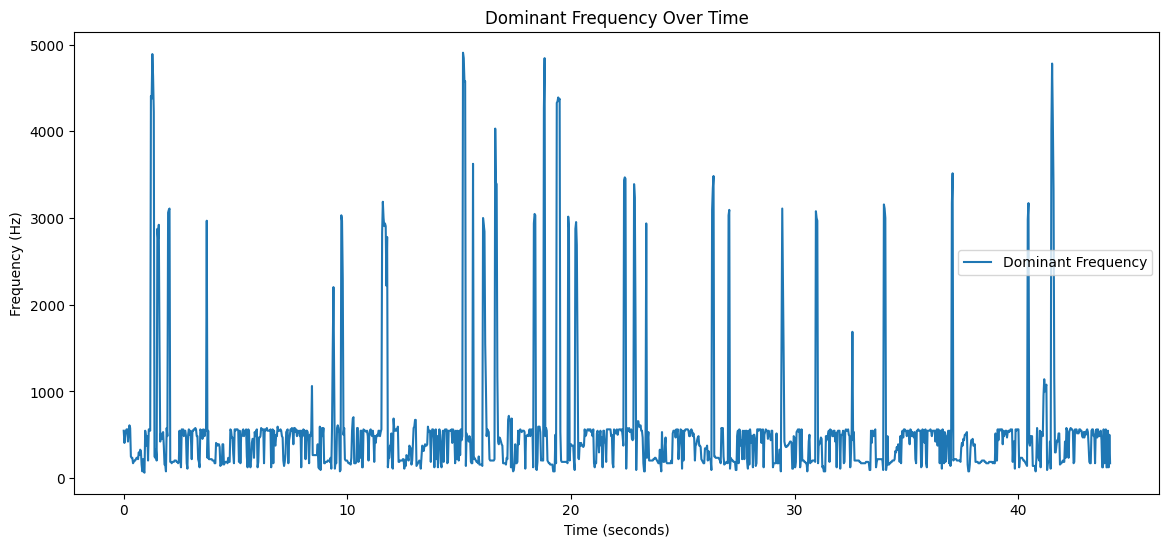

In [337]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def dominant_frequency(signal, sample_rate, window_size):
    """Calculate dominant frequency in each frame of the audio signal"""
    # Number of samples in each window
    step_size = window_size // 2
    frequencies = np.fft.rfftfreq(window_size, d=1./sample_rate)
    dominant_frequencies = []

    for i in range(0, len(signal) - window_size, step_size):
        # Windowing
        windowed_signal = signal[i:i + window_size] * np.hanning(window_size)
        # FFT
        magnitude = np.abs(np.fft.rfft(windowed_signal))
        # Find the peak in the FFT
        dominant_frequency = frequencies[np.argmax(magnitude)]
        dominant_frequencies.append(dominant_frequency)

    return dominant_frequencies

# Load the audio file
sample_rate, data = wavfile.read('/content/output_file.wav')

# Ensure audio is mono
if data.ndim > 1:
    data = data[:, 0]

# Parameters
window_size = 1024  # Adjust as necessary

# Calculate dominant frequencies
dom_freqs = dominant_frequency(data, sample_rate, window_size)

# Generate time values for each window
times = np.arange(len(dom_freqs)) * (window_size / 2) / sample_rate

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(times, dom_freqs, label='Dominant Frequency')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Dominant Frequency Over Time')
plt.legend()
plt.show()

After aligning the timestamps for each word, the amplitude waveform graph, pauses, and frequency, we can compile a table that includes the normalized amplitude, duration, pause, and frequency for each word. Research on poetry and emotion, as well as speech and emotion, indicates that these factors are crucial in determining the emotional impact of a poem presentation. In other words, we have extracted most, if not all, of the relevant information regarding the emotional content of the poem from the MP3 file and organized it into the table.

In [338]:
"""
from pydub import AudioSegment
import numpy as np

def perform_analysis(audio_file, word_timings, detected_pauses):
    audio = AudioSegment.from_wav(audio_file)
    analysis = []

    def find_pause_duration(start, end, pauses):
        pause_duration = 0
        for pause_start, pause_length in pauses:
            pause_end = pause_start + pause_length
            if pause_start >= start and pause_start < end:
                if pause_end <= end:
                    pause_duration += pause_length
                else:
                    pause_duration += end - pause_start
        return pause_duration

    previous_end_time = 0

    for i in range(len(word_timings) - 1):
        start_time, word = word_timings[i]
        next_start_time, _ = word_timings[i + 1]

        if previous_end_time != 0 and previous_end_time > start_time:
            start_time = previous_end_time

        word_end_time = next_start_time
        word_duration = word_end_time - start_time
        pause_duration = find_pause_duration(start_time, word_end_time, detected_pauses)
        actual_duration = word_duration - pause_duration

        segment = audio[start_time:word_end_time]
        samples = np.array(segment.get_array_of_samples())

        if len(samples) > 0:
            freq_spectrum = np.fft.fft(samples)
            freq_magnitudes = np.abs(freq_spectrum)
            freq_bins = np.fft.fftfreq(len(samples), 1 / segment.frame_rate)
            peak_freq = freq_bins[np.argmax(freq_magnitudes[:len(freq_magnitudes) // 2])]

            peak_amplitude = np.max(np.abs(samples))
            analysis.append({
                "文字": word,
                "声量": peak_amplitude,
                "发声时长": actual_duration,
                "停顿": pause_duration,
                "音高": peak_freq
            })

        previous_end_time = word_end_time

    if not analysis:
        return None

    amplitudes = [entry["声量"] for entry in analysis]
    durations = [entry["发声时长"] for entry in analysis]
    pauses = [entry["停顿"] for entry in analysis]
    frequencies = [entry["音高"] for entry in analysis]

    amp_thresholds = np.percentile(amplitudes, [33, 66])
    duration_thresholds = np.percentile(durations, [33, 66])
    pause_thresholds = np.percentile(pauses, [50])
    freq_thresholds = np.percentile(frequencies, [33, 66])

    categorized_data = []
    for entry in analysis:
        categorized_entry = {
            "文字": entry["文字"],
            "声量类别": ("Low" if entry["声量"] < amp_thresholds[0] else
                             "中" if entry["声量"] < amp_thresholds[1] else
                             "高"),
            "发声时长类别": ("短" if entry["发声时长"] < duration_thresholds[0] else
                                  "中" if entry["发声时长"] < duration_thresholds[1] else
                                  "短"),
            "停顿类别": ("无停顿" if entry["停顿"] == 0 else
                               "短" if entry["停顿"] < pause_thresholds[0] else
                               "长"),
            "音高类别": ("低" if entry["音高"] < freq_thresholds[0] else
                              "中" if entry["音高"] < freq_thresholds[1] else
                              "高")
        }
        categorized_data.append(categorized_entry)

    return categorized_data

# Example usage
audio_file = '/content/output_file.wav'


results = perform_analysis(audio_file, word_timings, pauses)
for result in results:
    print(f"文字: {result['文字'].strip()}, 声量: {result['声量类别']}, "
          f"发声时长: {result['发声时长类别']}, 停顿: {result['停顿类别']}, "
          f"音高: {result['音高类别']}")


"""

'\nfrom pydub import AudioSegment\nimport numpy as np\n\ndef perform_analysis(audio_file, word_timings, detected_pauses):\n    audio = AudioSegment.from_wav(audio_file)\n    analysis = []\n\n    def find_pause_duration(start, end, pauses):\n        pause_duration = 0\n        for pause_start, pause_length in pauses:\n            pause_end = pause_start + pause_length\n            if pause_start >= start and pause_start < end:\n                if pause_end <= end:\n                    pause_duration += pause_length\n                else:\n                    pause_duration += end - pause_start\n        return pause_duration\n\n    previous_end_time = 0\n\n    for i in range(len(word_timings) - 1):\n        start_time, word = word_timings[i]\n        next_start_time, _ = word_timings[i + 1]\n\n        if previous_end_time != 0 and previous_end_time > start_time:\n            start_time = previous_end_time\n\n        word_end_time = next_start_time\n        word_duration = word_end_time -

Better logic to classify the pauses compared with previous one
It filters out noise by only considering pauses > 100ms when calculating thresholds
It realistically considers small pauses (< 100ms) as "无停顿"
It has a fallback threshold of 500ms if no significant pauses are found

In [339]:
from pydub import AudioSegment
import numpy as np

def perform_analysis(audio_file, word_timings, detected_pauses):
    audio = AudioSegment.from_wav(audio_file)
    analysis = []

    def find_pause_duration(start, end, pauses):
        pause_duration = 0
        for pause_start, pause_length in pauses:
            pause_end = pause_start + pause_length
            if pause_start >= start and pause_start < end:
                if pause_end <= end:
                    pause_duration += pause_length
                else:
                    pause_duration += end - pause_start
        return pause_duration

    previous_end_time = 0

    for i in range(len(word_timings) - 1):
        start_time, word = word_timings[i]
        next_start_time, _ = word_timings[i + 1]

        if previous_end_time != 0 and previous_end_time > start_time:
            start_time = previous_end_time

        word_end_time = next_start_time
        word_duration = word_end_time - start_time
        pause_duration = find_pause_duration(start_time, word_end_time, detected_pauses)
        actual_duration = word_duration - pause_duration

        start_ms = int(start_time)
        end_ms = int(word_end_time)

        if start_ms < len(audio) and end_ms <= len(audio) and start_ms < end_ms:
            segment = audio[start_ms:end_ms]
            samples = np.array(segment.get_array_of_samples())

            if len(samples) > 0:
                freq_spectrum = np.fft.fft(samples)
                freq_magnitudes = np.abs(freq_spectrum)
                freq_bins = np.fft.fftfreq(len(samples), 1 / segment.frame_rate)
                peak_freq = freq_bins[np.argmax(freq_magnitudes[:len(freq_magnitudes) // 2])]

                peak_amplitude = np.max(np.abs(samples))
                analysis.append({
                    "文字": word,
                    "声量": peak_amplitude,
                    "发声时长": actual_duration,
                    "停顿": pause_duration,
                    "音高": peak_freq
                })

        previous_end_time = word_end_time

    if not analysis:
        return []

    amplitudes = [entry["声量"] for entry in analysis]
    durations = [entry["发声时长"] for entry in analysis]
    pauses = [entry["停顿"] for entry in analysis]
    frequencies = [entry["音高"] for entry in analysis]

    amp_thresholds = np.percentile(amplitudes, [33, 66])
    duration_thresholds = np.percentile(durations, [33, 66])
    pause_thresholds = np.percentile([p for p in pauses if p > 100], [50]) if any(p > 100 for p in pauses) else [500]
    freq_thresholds = np.percentile(frequencies, [33, 66])

    categorized_data = []
    for entry in analysis:
        categorized_entry = {
            "文字": entry["文字"],
            "声量类别": ("低" if entry["声量"] < amp_thresholds[0] else
                             "中" if entry["声量"] < amp_thresholds[1] else
                             "高"),
            "发声时长类别": ("短" if entry["发声时长"] < duration_thresholds[0] else
                                  "中" if entry["发声时长"] < duration_thresholds[1] else
                                  "短"),
            "停顿类别": ("无停顿" if entry["停顿"] < 100 else
                               "短" if entry["停顿"] < pause_thresholds[0] else
                               "长"),
            "音高类别": ("低" if entry["音高"] < freq_thresholds[0] else
                              "中" if entry["音高"] < freq_thresholds[1] else
                              "高")
        }
        categorized_data.append(categorized_entry)

    return categorized_data

# Example usage
audio_file = '/content/output_file.wav'

results = perform_analysis(audio_file, word_timings, pauses)
for result in results:
    print(f"文字: {result['文字'].strip()}, 声量: {result['声量类别']}, "
          f"发声时长: {result['发声时长类别']}, 停顿: {result['停顿类别']}, "
          f"音高: {result['音高类别']}")

文字: 感, 声量: 中, 发声时长: 中, 停顿: 无停顿, 音高: 低
文字: 遇, 声量: 低, 发声时长: 短, 停顿: 短, 音高: 高
文字: 四, 声量: 低, 发声时长: 中, 停顿: 无停顿, 音高: 高
文字: 首, 声量: 低, 发声时长: 中, 停顿: 无停顿, 音高: 高
文字: 之, 声量: 低, 发声时长: 短, 停顿: 无停顿, 音高: 低
文字: 一, 声量: 低, 发声时长: 短, 停顿: 短, 音高: 低
文字: 张, 声量: 高, 发声时长: 中, 停顿: 无停顿, 音高: 中
文字: 九, 声量: 低, 发声时长: 短, 停顿: 无停顿, 音高: 高
文字: 龄, 声量: 低, 发声时长: 短, 停顿: 长, 音高: 低
文字: 孤, 声量: 高, 发声时长: 中, 停顿: 无停顿, 音高: 高
文字: 鸿, 声量: 高, 发声时长: 短, 停顿: 无停顿, 音高: 高
文字: 海, 声量: 低, 发声时长: 短, 停顿: 短, 音高: 中
文字: 上来, 声量: 高, 发声时长: 短, 停顿: 短, 音高: 低
文字: 池, 声量: 中, 发声时长: 短, 停顿: 无停顿, 音高: 高
文字: 潢, 声量: 中, 发声时长: 短, 停顿: 无停顿, 音高: 中
文字: 不敢, 声量: 高, 发声时长: 短, 停顿: 无停顿, 音高: 中
文字: 顾, 声量: 高, 发声时长: 短, 停顿: 长, 音高: 高
文字: 侧, 声量: 高, 发声时长: 中, 停顿: 无停顿, 音高: 高
文字: 见, 声量: 高, 发声时长: 短, 停顿: 无停顿, 音高: 低
文字: 双, 声量: 高, 发声时长: 短, 停顿: 无停顿, 音高: 中
文字: 翠鸟, 声量: 高, 发声时长: 短, 停顿: 短, 音高: 低
文字: 巢, 声量: 高, 发声时长: 中, 停顿: 无停顿, 音高: 低
文字: 在, 声量: 高, 发声时长: 短, 停顿: 无停顿, 音高: 高
文字: 三, 声量: 中, 发声时长: 短, 停顿: 无停顿, 音高: 低
文字: 珠, 声量: 低, 发声时长: 中, 停顿: 无停顿, 音高: 低
文字: 树, 声量: 中, 发声时长: 短, 停顿: 长, 音高: 高
文字: 瞧瞧, 声量: 高, 发声时长: 短, 停

Store the table and poem in variables for future use.

In [340]:
print(results)

[{'文字': '感', '声量类别': '中', '发声时长类别': '中', '停顿类别': '无停顿', '音高类别': '低'}, {'文字': '遇', '声量类别': '低', '发声时长类别': '短', '停顿类别': '短', '音高类别': '高'}, {'文字': '四', '声量类别': '低', '发声时长类别': '中', '停顿类别': '无停顿', '音高类别': '高'}, {'文字': '首', '声量类别': '低', '发声时长类别': '中', '停顿类别': '无停顿', '音高类别': '高'}, {'文字': '之', '声量类别': '低', '发声时长类别': '短', '停顿类别': '无停顿', '音高类别': '低'}, {'文字': '一', '声量类别': '低', '发声时长类别': '短', '停顿类别': '短', '音高类别': '低'}, {'文字': '张', '声量类别': '高', '发声时长类别': '中', '停顿类别': '无停顿', '音高类别': '中'}, {'文字': '九', '声量类别': '低', '发声时长类别': '短', '停顿类别': '无停顿', '音高类别': '高'}, {'文字': '龄', '声量类别': '低', '发声时长类别': '短', '停顿类别': '长', '音高类别': '低'}, {'文字': '孤', '声量类别': '高', '发声时长类别': '中', '停顿类别': '无停顿', '音高类别': '高'}, {'文字': '鸿', '声量类别': '高', '发声时长类别': '短', '停顿类别': '无停顿', '音高类别': '高'}, {'文字': '海', '声量类别': '低', '发声时长类别': '短', '停顿类别': '短', '音高类别': '中'}, {'文字': '上来', '声量类别': '高', '发声时长类别': '短', '停顿类别': '短', '音高类别': '低'}, {'文字': '池', '声量类别': '中', '发声时长类别': '短', '停顿类别': '无停顿', '音高类别': '高'}, {'文字': '潢', '声量类别': '中', '发声时长类别': '短', '停

As previously mentioned, nearly all the useful information from the MP3 file has been extracted and organized into a textual table. We are now ready to leverage the impressive zero-shot capabilities of large language models (LLMs). The earlier steps involved using various methods to extract information from the audio file and attempting to reproduce the audio in textual form, aligning with the strengths of LLMs.

With two prompts—one asking the LLM to analyze the given poem and the second providing data from a student presentation to give feedback—we can demonstrate that this approach leads to improved performance.

The concept of converting audio files to text and utilizing LLMs is inspired by research on prompt-based time series analysis using LLMs. The rationale for employing LLMs as the final stage is twofold: first, their zero-shot abilities; and second, findings from previous studies on poetry and emotion. These studies indicate that the accurate expression of emotions in poem presentations is determined by analyzing the words and sentences of the poem, while emotional expression is reflected through the control of stress, pace, pauses, duration, and tone, all of which are subjective and relative to the individual. Consequently, there are no definitive "positive" samples in this area.

In [341]:
import pandas as pd
from zhipuai import ZhipuAI
from functools import lru_cache

# Initialize ZhipuAI client
client = ZhipuAI(api_key="968cd0b672b9b5133d01741721558a95.xYFanKwaJ2ShpQuZ")

# List to hold the conversation history
conversation_history = []

# Function to add a message to the conversation history
def add_to_history(role, content):
    conversation_history.append({"role": role, "content": content})

@lru_cache(maxsize=128)
def get_response_from_api(messages_tuple):
    messages = [dict(m) for m in messages_tuple]
    response = client.chat.completions.create(
        model="glm-4",
        messages=messages
    )
    return response.choices[0].message.content

def get_correct_poem_presentation(poem_content):
    add_to_history("user", f"作为老师，请用纯中文分析这首古诗的朗读技巧，避免使用任何英文。请从声音重点、停顿、节奏和语调方面逐句分析。\n{poem_content}")
    messages_tuple = tuple(tuple(d.items()) for d in conversation_history)
    return get_response_from_api(messages_tuple)

def correct_student_presentation():
    add_to_history("user", f"请用纯中文分析这位学生的朗读表现。我已将音频文件转换为文字描述：文字部分是学生朗读的内容，声量分为高中低三类，发声时长分为长中短三类，停顿时长分为长中短三类，音高也分为高中低三类。请逐句分析朗读情感并指出改进建议。\n{results}")
    messages_tuple = tuple(tuple(d.items()) for d in conversation_history)
    return get_response_from_api(messages_tuple)

print(get_correct_poem_presentation(poem_content))
print(correct_student_presentation())

这首古诗的朗读技巧可以从以下几个方面进行逐句分析：

1. **声音重点**：
   - “孤鸿海上来”：重点在“孤”字，表达孤独、寂寥之情，应加重语气。
   - “池潢不敢顾”：重点在“不敢”两字，体现孤鸿的谨慎与畏惧，读时应稍作停顿，强调“不敢”。
   - “侧见双翠鸟”：重点在“双翠鸟”，描绘了一幅色彩鲜明的画面，读时应加重语气，突出形象。
   - “巢在三珠树”：重点在“三珠树”，读时应清晰有力，显现树木的珍贵。
   - “矫矫珍木巅”：重点在“矫矫”，形容树木之高，读时应提高声调，表现树木的高大。
   - “得无金丸惧”：“金丸惧”是诗眼，读时应加重语气，表现出诗人的担忧。
   - “美服患人指”：重点在“患人指”，表达了一种忧虑，读时应稍显沉重。
   - “高明逼神恶”：“高明”与“神恶”形成对比，读时应强调这两个词，展现诗人的反思。
   - “今我游冥冥”：重点在“冥冥”，形容自己如行走在迷雾之中，语气应显得迷茫。
   - “弋者何所慕”：“何所慕”是问句，读时应提高语调，表现出疑问与追求。

2. **停顿**：
   - 在句与句之间应有适当的停顿，以区分诗句的界限，如“孤鸿海上来”之后稍作停顿，再继续下一句。
   - 在诗句内部，如“池潢不敢顾”、“得无金丸惧”等，在“不敢”、“得无”之后可以稍作停顿，以突出诗句的情感。

3. **节奏**：
   - 整首诗节奏宜保持平稳，每句诗的朗读节奏可以大致相同，形成一种循环往复的韵律美。
   - 每句内部，如“孤鸿海上来”四字，可按照古诗的平仄规律，读成“平仄平仄”的节奏。

4. **语调**：
   - 整体语调宜保持起伏有致，体现出诗的抑扬顿挫。
   - 在表达疑问或感慨的诗句，如“得无金丸惧”和“弋者何所慕”，读时语调应上扬，表现出诗人的情感变化。

通过以上分析，朗读这首古诗时，可以更好地把握其情感与意境，传达出诗人的内心世界。
以下是对该学生朗读古诗《孤雁》的分析及建议：

**孤鸿海上来，池潢不敢顾。**
- “孤鸿”两字应强调孤独与高洁的意境，建议“孤”字声音可以再提高一些，发音时长可稍长，以突出孤寂感；“海上来”语调应由低到高，表示孤鸿的远来与上升。
- “池潢不敢顾”中，“不敢”表达了一种畏惧和小心，应在“不敢”两字上加强语气，声音可更饱满，以表现鸿雁的谨慎